# 1. Motivation
In Machine Learning, there are commonly two problems (functions) that need to be optimized:

$$\begin{alignat}{3}
f &:\text{parameter} &&\rightarrow\text{loss} \qquad &&(1) \\
f &:\text{hyperparameter} &&\rightarrow\text{score}\qquad &&(2)
\end{alignat}$$

The first problem is nothing but the training/fitting step; the loss function $\mathcal{L}$ to be minimized is known and more importantly, *differentiable*. Therefore, a gradient-based method such as Gradient Descent can be used to estimate model parameters.

The second one (also known as hyperparameter tuning) does not have a mathematical form and thus cannot be solved using Gradient Descent. The optimal set of hyperparameters is usually found either by Data Scientists using rule of thumb or by searching methods. However, each trial is expensive and we must find the optimal configurations with as few trials as possible.

Scoring strategies in Machine Learning can be either *higher is better* (R2, AUC, F1,...) or *lower is better* (RMSE, MAE,...). To make things consistant, we assume all evaluation metrics are higher better.

## 1.1. Exhausted search
There are two popular methods of searching hyperparameters, Grid Search and Random Search. The idea of each method are already explained clearly in the image below, where the red area shows how much each hyperparameter contributes to model score.

<img src='image/grid_random_search.png' style='width:450px; margin:20px auto;'>

Grid Search goes to every possible combinations, and thus it will revisit a parameter value multiple times. This makes Grid Search have a low coverage and is very expensive, especially for algorithms with a huge number of hyperparameters such as XGBoost and LightGBM.

Random Search is a more efficient method, it randomly takes a number combinations to train models. With the same number of iterations provided, Random Search can cover a wider range of values, and thus it is able to reach the optimal value that Grid Search cannot. Another advantage is that you can include less important hyperparameters in your search without increasing the number of trials.

## 1.2. Sequential search
It's not difficult to see that searching methods perform expensive trials independently, thus they are actually wasting a lot of useful information from previous trials. In order to take advantages of historical information, SMBO (**S**equential **M**odel-**B**ased **O**ptimization) comes to the rescue. This is a class contains algorithms that *smartly* predict the most promising configuration *sequentially*, thus reduce the number of training rounds needed significantly.

The basic idea of SMBO is to build a *probabilistic surrogate model* of the black-box function $f:\text{hyperparameter}\rightarrow\text{score}$ using results from observed trials. You can think of it as Machine Learning of Machine Learning; this concept can be a bit complicated but is exactly how it works. There are many algorithms using this sequential search strategy, but in this topic, we are discussing Bayesian Optimization and Tree-structured Parzen Estimators.

# 2. Bayesian Optimization
A SMBO using Gaussian Process as the surrogate function is called **B**ayesian **O**ptimization (BO), since Gaussian Process use Bayes' rule to update the posterior distribution. It has some disadvantages:
- It does not support categorical hyperparameters, such as impurity criterion in Decision Tree.
- Gaussian Process does not scale very well

## 2.1. Algorithm
*Input*:
- A domain, or search space of hyperparameters
- $f$, the black-box function to be optimized, it maps hyperpameters to model score: $y=f(x)$ and is very expensive to evaluate
- $T$, the number of trials budget
- $\mathcal{S}$, a surrogate model (Gaussian Process) which takes finished trials as input then returns a distribution of model score for each unobserved trial
- $\mathcal{A}$, an acquisition function for deciding where the next trial should locate at

*Step 1*: Create a set $\mathcal{H}$ for storing historical trials $(x,y)$ with a randomly initialized trial $(x_0,y_0)$.

*Step 2*: For each trial $t$ for $t=1,2,\dots,T$:
- Fit the surrogate model on $\mathcal{H}$ to get $\mathcal{S}_t$
- Compute the acquisition function $\mathcal{A}_t(x)$ using $\mathcal{S}_t$ and $\mathcal{H}$
- Evaluate the most promising query point $x_t=\arg\max\mathcal{A}_t(x)$
- Train the expensive Machine Learning model using hyperparameters $x_t$ and compute its score $y_t=f(x_t)$
- Append the result $(x_t,y_t)$ to $\mathcal{H}$

## 2.2. Acquisition functions
Acquisition function is a very important component of SMBO, it defines the strategy to select the next set of hyperparameters to be used in training Machine Learning model. Acqusition functions control the balance between *exploitation* and *exploration*. In this section, we learn about 4 most popular options, using these notations:
- $x^\star,y^\star$ are the best hyperparameters so far in $\mathcal{H}$ and the associated model score
- $\varphi(\cdot)$ and $\psi(\cdot)$ indicate the PDF and CDF, respectively
- $\mu_y$ and $\sigma_y$ indicate the mean and standard deviation of model score according to the surrogate model

### Probability of Improvement
The idea of PI is very simple, it measures, at each unused configuration $x$, the probability that the corresponding score $y$ is higher than the current best score $y^\star$. A small positive offset $\epsilon$ is added to maintain the trade-off between *exploration* and *exploitation*.

$$\text{PI}=\text{Prob }(y>y^\star+\epsilon)$$

The intuition behind $\epsilon$ is all about *uncertainty*. For certain areas, the distribution of model scores are clustered around the mean, so that only a small $\epsilon$ penalizes their PI a lot. For this reason, higher values of $\epsilon$ favor exploration; but if too high, the behaviour will be a lot like [Active Learning](<https://en.wikipedia.org/wiki/Active_learning_(machine_learning)>). A balanced $\epsilon$ will make SMBO explore *just enough* and spend trials effectively on exploitation.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt; plt.style.use(['seaborn', 'seaborn-whitegrid'])
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
%config InlineBackend.figure_format = 'retina'

In [2]:
f = lambda x: 0.009*x**5 + 0.06*x**4 - 0.03*x**3 - 0.72*x**2 - 0.75*x + 1.8

np.random.seed(7)
xTrain = np.array([-4, 0.5, 1.5, 3])
yTrain = f(xTrain)

xTest = np.linspace(-5, 3.5, 100)
yTest = f(xTest)

In [3]:
algo = GaussianProcessRegressor()
model = algo.fit(xTrain.reshape(-1,1), yTrain)
meanPred, sigmaPred = model.predict(xTest.reshape(-1,1), return_std=True)
lower, upper = meanPred - sigmaPred, meanPred + sigmaPred

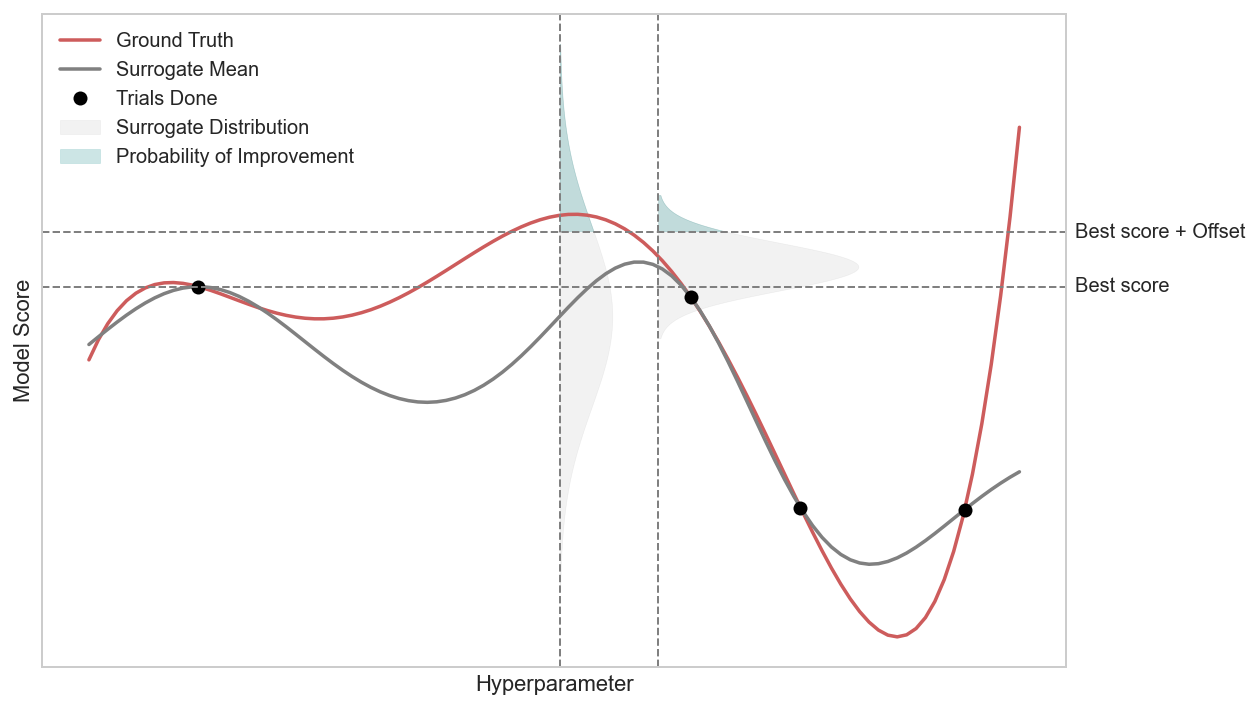

In [6]:
eps = 0.5
yStar = yTrain.max()
yThres = yStar + eps

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(xTest, yTest, 'indianred', label='Ground Truth')
ax.plot(xTest, meanPred, color='grey', label='Surrogate Mean')
ax.plot(xTrain, yTrain, 'ok', label='Trials Done')

ax.axhline(yTrain.max(), ls='--', lw=1, c='grey')
ax.axhline(yTrain.max()+eps, ls='--', lw=1, c='grey')

yStar = yTrain.max()
yThres = yStar + eps
ax.text(ax.get_xlim()[1]*1.02, yStar, 'Best score', va='center', ha='left')
ax.text(ax.get_xlim()[1]*1.02, yThres, 'Best score + Offset', va='center', ha='left')

for idx, xQuery in enumerate([-0.7, 0.2]):
    xQuery = np.array(xQuery)
    muQuery, sigmaQuery = model.predict(xQuery.reshape(-1,1), return_std=True)
    muQuery, sigmaQuery = muQuery[0], sigmaQuery[0]
    distQuery = stats.norm(muQuery, sigmaQuery)
    lowerQuery, upperQuery = muQuery - 3*sigmaQuery, muQuery + 3*sigmaQuery
    yPlot = np.linspace(lowerQuery, upperQuery, 100)
    xPlot = xQuery + distQuery.pdf(yPlot)
    yPI = yPlot[yPlot > yThres]
    xPI = xQuery + distQuery.pdf(yPI)
    
    ax.axvline(xQuery, ls='--', lw=1, c='grey')
    if idx == 0:
        ax.fill_betweenx(yPlot, xPlot, xQuery, color='grey', alpha=0.1, label='Surrogate Distribution')
        ax.fill_betweenx(yPI, xPI, xQuery, color='teal', alpha=0.2, label='Probability of Improvement')
    else:
        ax.fill_betweenx(yPlot, xPlot, xQuery, color='grey', alpha=0.1)
        ax.fill_betweenx(yPI, xPI, xQuery, color='teal', alpha=0.2)
        

ax.axis('scaled')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend()
ax.grid(False)
ax.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.set_xlabel('Hyperparameter')
ax.set_ylabel('Model Score')
plt.show()

### Expected Improvement
As PI only considers *how likely* to improve, we need EI to answer *how much* the improvement can be. We simply measure the [expected value](https://en.wikipedia.org/wiki/Expected_value#Random_variables_with_density) of improvement $y-y^\star$, or more percisely, $\max(y-y^\star-\epsilon,0)$. In the later formula, we are clipping negative improvements at zero. An offset $\epsilon$ is also added with the same intuition as in Probability of Improvement.

$$\text{EI}=\int_{-\infty}^{\infty} {(y-y^\star-\epsilon)\,\varphi(y)\,\text{d}y}$$

As EI and PI overcome the limitation of the other, we can combine them: $\text{PI}+\lambda\text{EI}$ to get a new acquisition function, PI-EI.

### Upper Confidence Bound
This acquisition function is a linear combination of the surrogate mean $\mu_y$ and the surrogate uncertainty $\sigma_y$. A multiplier $\lambda$ is attached to $\sigma_y$, it also favors *exploration*.

$$\text{UCB}=\mu_y+\lambda\sigma_y$$

### Thomson Sampling
As its name states, this method randomly samples a function that follows the surrogate distribution at each trial. Such a stochastic behaviour is non-deterministic in short-term but can converge in long-term as it is naturally exploration-exploitation balance.

## 2.3. Implementation

# 3. Parzen Estimators
Parzen-window Estimation is another name of [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) which is usually included in histograms. **T**ree-structured **P**arzen **E**stimators (TPE) is an algorithm of SMBO family and is proposed in the same paper with BO. TPE estimates the likelihood $\text{Pr }(x|y)$ rather than the posterior $\text{Pr }(y|x)$ as in BO.

## 3.1. Algorithm
*Input*:
- A domain, or search space of hyperparameters
- $f$, the black-box function to be optimized, it maps hyperpameters to model score: $y=f(x)$ and is very expensive to evaluate
- $T$, the number of trials budget
- $\mathcal{A}$, an acquisition function for deciding where the next trial should locate at

*Step 1*: Warm up several trials using Random Search. The observed score is splited into two groups: low and high score. The high score group is usually 10-25% number of observed trials.

*Step 2*: Construct KDE for two groups, denoted $l(x)$ and $h(x)$, respectively.

- https://blog.csdn.net/weixin_41521681/article/details/108392570

## 3.2. Implementation

# 4. HyperBand

# 4. Implementation

# References
- *papers.nips.cc* - [Algorithms for Hyper-parameters Optimization](https://papers.nips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)
- *openreview.net* - [Hyperband: Bandit-based configuration evaluation for hyperparameter optimization](https://openreview.net/pdf?id=ry18Ww5ee)
- *medium.com* - [A Conceptual Explanation of Bayesian Hyperparameter Optimization for Machine Learning](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
- *medium.com* - [Hyper-parameter optimization algorithms: a short review](https://medium.com/criteo-engineering/hyper-parameter-optimization-algorithms-2fe447525903)
- *krasserm.github.io* - [Bayesian Optimization](https://krasserm.github.io/2018/03/21/bayesian-optimization/)
- *distill.pub* - [Exploring Bayesian Optimization](https://distill.pub/2020/bayesian-optimization/)
- *borealisai.com - [Tutorial #8: Bayesian optimization](https://www.borealisai.com/research-blogs/tutorial-8-bayesian-optimization/)*

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*